In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import cirq
import cirq_superstaq as css
import ldpc
import matplotlib.pyplot as plt
import numpy as np
import pymatching
import sinter
import stim
import stimcirq
from ldpc.sinter_decoders import SinterBeliefFindDecoder, SinterBpOsdDecoder

import qldpc

In [3]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int, decompose_errors=True, ignore_decomposition_failures=False) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model()
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [4]:
surface_code = qldpc.codes.SurfaceCode(3, rotated=True)
# surface_code.reduce_logical_ops()

def gen_syndrome_surface_circuit(surface_code, repetitions=1, error_rate=0.01):
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    logical_x = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
    logical_z = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)

    count = 0
    measures = []
    hs = []
    for anc_idx, row in enumerate(surface_code.matrix_x):
        count += 1
        anc = cirq.NamedQubit(f"a{anc_idx}")
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
        hs.append(cirq.H(anc))
        measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on(anc))

    stab_circuit += cirq.Moment(hs)
    for anc_idx, row in enumerate(surface_code.matrix_z, start=count):
        anc = cirq.NamedQubit(f"a{anc_idx}")
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
        measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on(anc))

    # First round of stabilizer checks
    circuit = stab_circuit.copy()
    
    circuit += cirq.Moment(measures)

    ancillas = sorted([q for q in circuit.all_qubits() if isinstance(q, cirq.NamedQubit)])
    data = sorted([q for q in circuit.all_qubits() if q not in ancillas])

    circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x], coordinate_metadata = (i, 0)) for i, x in enumerate(range(-len(ancillas), int(-len(ancillas)/2)))])


    
    # Repeat Block
    circuit_op = stab_circuit
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    moment += cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    circuit_op += moment
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x, x-len(ancillas)], coordinate_metadata = (i, 0)) for i, x in enumerate(range(-len(ancillas), 0))])
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))


    for idx, d in enumerate(data):
        circuit += cirq.Z.with_probability(error_rate).on(d) 
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    moment = []
    for i, anc_idx in enumerate(range(len(ancillas)//2)):
        data_indices = [idx - len(data) for idx, element in enumerate(surface_code.matrix_x[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits())] + data_indices, coordinate_metadata = (i, 1)))

    circuit += cirq.Moment(moment)

    for i, lx in enumerate(logical_x):
        observable_keys = [idx - len(data) for idx, element in enumerate(lx) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))

    # circuit.insert(0, cirq.reset_each(*circuit.all_qubits()))
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in data])
    moment += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='Z', invert_measure=False, key="").on(q) for q in ancillas])
    circuit.insert(0, moment)
    # return circuit.with_noise(cirq.depolarize(error_rate))
    return circuit

surface_circuit = gen_syndrome_surface_circuit(surface_code, 10)
# surface_circuit

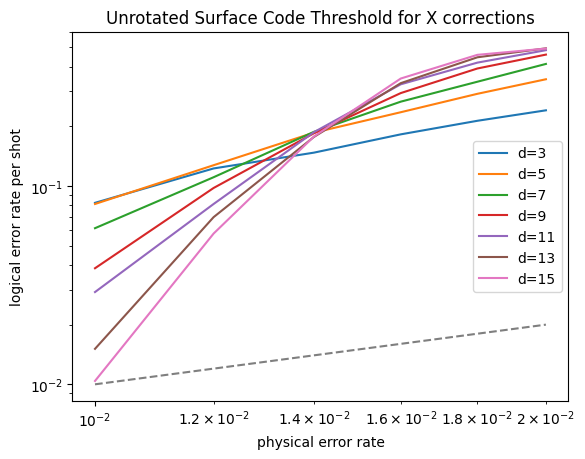

In [5]:
import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7, 9, 11, 13, 15]:
    sc = qldpc.codes.SurfaceCode(d, rotated=False)
    xs = []
    ys = []
    for noise in [0.01, 0.012, 0.014, 0.016, 0.018, 0.02]:
        circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(sc, 3*d, noise))
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for X corrections")
plt.legend()
plt.show()

In [6]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-3.5, -1, 7)
code_name = "Unrotated Surface Code"
base_code = qldpc.codes.HammingCode(2)
group = qldpc.abstract.CyclicGroup(4)
code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3, 5, 7, 9]:
            code = qldpc.codes.SurfaceCode(d, rotated=False)
            circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, repetitions=d, error_rate=noise))
            yield sinter.Task(
                circuit=circuit,
                detector_error_model=circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation():
    samples = sinter.collect(
        num_workers=10,
        max_shots=200_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=f'bposd_{("_".join(code_name.split())).lower()}.csv',
    )
    return(samples)

In [7]:
samples = run_simulation()
samples

Starting 10 workers...
Finding work...
There was nothing additional to collect


[sinter.TaskStats(strong_id='1484df7fb82eaf16cbe4fa29c30bcb92e487eb9e77624349ef62e66abe2d69e5', decoder='bposd', json_metadata={'d': 3, 'noise': 0.00031622776601683794, 'repetitions': 3}, shots=200000, errors=12, seconds=9.972999999999999),
 sinter.TaskStats(strong_id='25490746b617f6ac66eac59b74e719dbb44ef1c95e6365005ae56ebd054141b8', decoder='bposd', json_metadata={'d': 5, 'noise': 0.00031622776601683794, 'repetitions': 5}, shots=200000, seconds=33.608999999999995),
 sinter.TaskStats(strong_id='b89ac146678759215e5072960c7cff356ac3c09e8bafa5b816d7c6400fd4f70f', decoder='bposd', json_metadata={'d': 7, 'noise': 0.00031622776601683794, 'repetitions': 7}, shots=200000, seconds=110.893),
 sinter.TaskStats(strong_id='17d0f203eab3796f453a9728b483d3c48cef6befea4b72bc8f7427c69eddcbe5', decoder='bposd', json_metadata={'d': 3, 'noise': 0.0008254041852680181, 'repetitions': 3}, shots=200000, errors=57, seconds=10.0),
 sinter.TaskStats(strong_id='00db0dcd000c90128e53609b969402d0f61fdad92ea4dcacd8b5

In [8]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    sinter.plot_error_rate(
        ax=axis,
        stats=samples,
        group_func=lambda stat: f"{code_name} d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        x_func=lambda stat: stat.json_metadata['noise'],
    )

    axis.set_ylabel('Logical Error Rate')
    axis.set_title(f'{code_name} threshold with BPOSD')

    axis.plot(noise_range, noise_range, "--", color="k")
    axis.loglog()
    axis.grid()
    axis.set_xlabel('Physical Error Rate')
    axis.legend()

    # Save to file and also open in a window.
    fig.savefig('plot.png')
    plt.show()

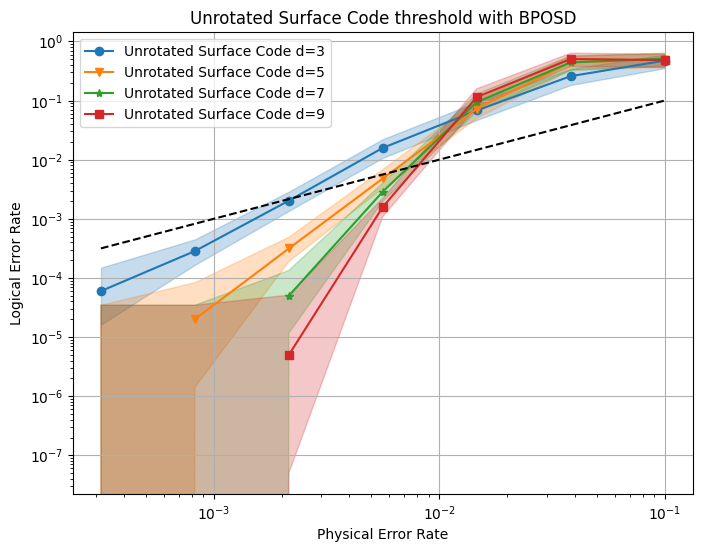

In [9]:
plot_results(samples)

# Code Archive

In [ ]:
def stim_steane_code(error_rate):
# steane code metadata
    steane_code = qldpc.codes.SteaneCode()
    code = steane_code
    repetitions = 10
    stabilizers = []
    
    circuit = cirq.Circuit()
    ancillas = []
    stab_circuit = cirq.Circuit()
    for anc_idx, check in enumerate(code.matrix_x):
        anc = cirq.NamedQubit(f"a{anc_idx}")
        # anc = cirq.LineQubit(7 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CX(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
        
    # circuit += css.barrier(*circuit.all_qubits())
    
    for anc_idx, check in enumerate(code.matrix_z):
        anc = cirq.NamedQubit(f"a{anc_idx + 3}")
        # anc = cirq.LineQubit(7 + 3 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CZ(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CZ(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
    data = sorted([q for q in stab_circuit.all_qubits() if isinstance(q, cirq.LineQubit)])
    qubits = list(stab_circuit.all_qubits())
    
    circuit = cirq.Circuit()
    for q in qubits:
        # circuit += cirq.R(q)
        circuit += stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q)
    stab_circuit = cirq.Circuit()
    stab_circuit += cirq.Moment([cirq.depolarize(error_rate).on(d) for d in data] + cirq.H.on_each(ancillas))
    stab_circuit += cirq.Circuit(cirq.Moment(stab) for stab in stabilizers)
    stab_circuit += cirq.Moment(cirq.H.on_each(ancillas))
    circuit += stab_circuit
    circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    circuit += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    circuit += cirq.Moment(
        stimcirq.DetAnnotation(relative_keys=[-6], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-5], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-4], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-3], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-2], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-1], coordinate_metadata=(12.0, 0.0))
    )
    
    circuit_op = stab_circuit
    circuit_op += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))

    moment += cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    moment += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[-len(ancillas) + idx, idx], coordinate_metadata=(len(qubits) + idx, 0)) for idx in range(-len(ancillas), 0)])

    # moment += cirq.Moment(
    #     stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-12, -6], coordinate_metadata=(7.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-11, -5], coordinate_metadata=(8.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-10, -4], coordinate_metadata=(9.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-9, -3], coordinate_metadata=(10.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-8, -2], coordinate_metadata=(11.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-7, -1], coordinate_metadata=(12.0, 0.0))
    # )
    
    circuit_op += moment
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    for idx, d in enumerate(data):
        circuit += cirq.X.with_probability(error_rate).on(d)
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    
    circuit += cirq.Moment(
        stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
        stimcirq.DetAnnotation(relative_keys=[-13, -1, -2, -3, -4], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-12, -1, -2, -5, -6], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-11, -1, -3, -5, -7], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-10, -1, -2, -3, -4], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-9, -1, -2, -5, -6], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-8, -1, -3, -5, -7], coordinate_metadata=(12.0, 0.0))
    )
    circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(relative_keys=[-1, -2, -3], observable_index=0))
    
    # return circuit.with_noise(cirq.depolarize(noise))
    return circuit